## pymysql 패키지 설치

In [1]:
!pip install pymysql

     |████████████████████████████████| 43 kB 1.6 MB/s 


## 패키지 불러오기

In [2]:
import pymysql

In [10]:
url='database-1.crgynijfr6gz.ap-northeast-2.rds.amazonaws.com'
id='user'
pwd='1234'
port=3306
db='flight_delay'

## 데이터베이스 접속
## conn 객체를 이용하여 접속 컨트롤 가능
conn=pymysql.connect(host=url,user=id,password=pwd,database=db,port=port)


In [60]:
## 커서지정 (현재 할일)
cur = conn.cursor()

In [61]:
## 쿼리문 원격실행
sql = "SELECT * FROM days" #쿼리문은 문자열로
cur.execute(sql) # 커서의 execute 명령어로 쿼리 실행
output=cur.fetchall() # 쿼리 실행결과를 파이썬 객체로 반환
print(output) #확인

((1, 'Monday'), (2, 'Tuesday'), (3, 'Wednesday'), (4, 'Thursday'), (5, 'Friday'), (6, 'Saturday'), (7, 'Sunday'), (9, 'Unknown'))


In [62]:
for i in output:
    print(i)

(1, 'Monday')
(2, 'Tuesday')
(3, 'Wednesday')
(4, 'Thursday')
(5, 'Friday')
(6, 'Saturday')
(7, 'Sunday')
(9, 'Unknown')


In [63]:
#접속 끊기
conn.close()

In [64]:
#접속 끊은 후에는 커서가 실행되지 않음
cur.execute(sql) # 커서의 execute 명령어로 쿼리 실행
print(output) #확인

InterfaceError: ignored

In [65]:
#다음처럼 재접속해야함
conn=pymysql.connect(host=url,user=id,password=pwd,database=db,port=port)
cur=conn.cursor()

## 복잡한 쿼리응용사례

쿼리문 어떤 공항이 가장 사용량이 많았는가?

In [16]:
sql = '''
SELECT 
origin, 
airports.airport_name,
COUNT(*) AS NUMBER
FROM flights
JOIN airports 
ON flights.origin=airports.code
GROUP BY origin
ORDER BY NUMBER DESC  
LIMIT 10
'''
cur.execute(sql)
output=cur.fetchall()
for i in output:
    print(i)

('ATL', ' Hartsfield-Jackson Atlanta International', 28630)
('DFW', ' Dallas/Fort Worth International', 26507)
('DEN', ' Denver International', 25629)
('ORD', " Chicago O'Hare International", 25349)
('CLT', ' Charlotte Douglas International', 18645)
('LAX', ' Los Angeles International', 17684)
('SEA', ' Seattle/Tacoma International', 16617)
('PHX', ' Phoenix Sky Harbor International', 14387)
('LAS', ' McCarran International', 13481)
('IAH', ' George Bush Intercontinental/Houston', 12867)


## 파이썬 DataFrame 객체로 실행결과 변환

In [18]:
import pandas as pd
df=pd.DataFrame(output)
df.columns = ['code','name','count'] # 열이름 다시 잡아주기

In [19]:
df

,code,name,count
0,ATL,Hartsfield-Jackson Atlanta International,28630
1,DFW,Dallas/Fort Worth International,26507
2,DEN,Denver International,25629
3,ORD,Chicago O'Hare International,25349
4,CLT,Charlotte Douglas International,18645
5,LAX,Los Angeles International,17684
6,SEA,Seattle/Tacoma International,16617
7,PHX,Phoenix Sky Harbor International,14387
8,LAS,McCarran International,13481
9,IAH,George Bush Intercontinental/Houston,12867


<BarContainer object of 10 artists>

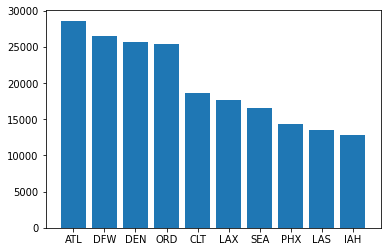

In [20]:
## 그래프로 결과 가공하기
import matplotlib.pyplot as plt
plt.bar(df['code'],df['count'])

## 문제2: LAS 공항에서 가장 바쁜날이 일주일 중 언제인가?

In [54]:
sql = '''
SELECT 
dayofwk,
days.day,
COUNT(*) AS NUMBER
FROM flights
JOIN days
ON flights.dayofwk = days.code
WHERE origin = 'LAS' OR dest = 'LAS'
GROUP BY dayofwk
ORDER BY NUMBER DESC
'''
cur.execute(sql)
output=cur.fetchall()
df = pd.DataFrame(output)


,code,week,count
0,5,Friday,4711
1,4,Thursday,4660
2,6,Saturday,3783
3,1,Monday,3729
4,7,Sunday,3567
5,3,Wednesday,3299
6,2,Tuesday,3216


In [55]:
# 컬럼명 다시 잡아주기
df.columns=['code','week','count']
df

,code,week,count
0,5,Friday,4711
1,4,Thursday,4660
2,6,Saturday,3783
3,1,Monday,3729
4,7,Sunday,3567
5,3,Wednesday,3299
6,2,Tuesday,3216


In [57]:
# code 열로 다시 정렬 (월~금)
df=df.sort_values(by=['code'])
df

,code,week,count
3,1,Monday,3729
6,2,Tuesday,3216
5,3,Wednesday,3299
1,4,Thursday,4660
0,5,Friday,4711
2,6,Saturday,3783
4,7,Sunday,3567


<BarContainer object of 7 artists>

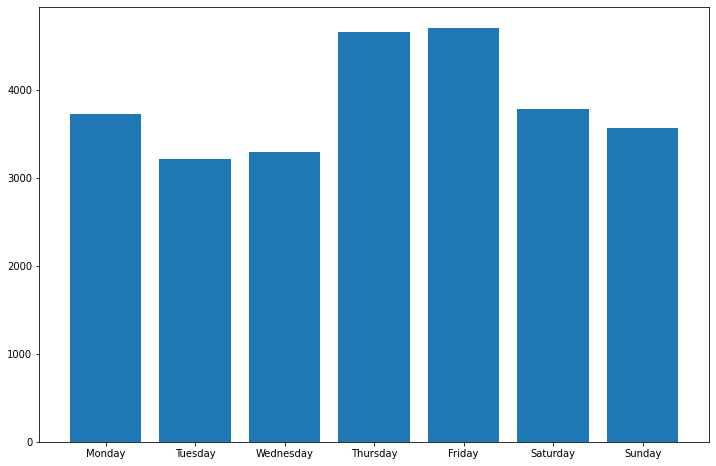

In [59]:
plt.figure(figsize=(12,8)) # 그림크기 조정
plt.bar(df['week'],df['count']) #바차트 만들기

## 또다른 예시

도착 지연의 주요 원인은 무엇인가?

In [51]:
sql = '''
SELECT AVG(ad_carrier), 
    AVG(ad_whether), 
    AVG(ad_nas), 
    AVG(ad_security), 
    AVG(ad_late_aircraft)
FROM flights
WHERE arr_del>0
'''
cur.execute(sql)
output=cur.fetchall()
df = pd.DataFrame(output)


In [42]:
result=[] #처리된 결과를 담을 빈 리스트
for i in output[0]:
    result.append(float(i)) # float 데이터의 경우 처리가 지저분하여 다음과 같이 처리함

In [43]:
result # 평균 분수를 파이의 크기로 사용할 것임

[15.8324, 2.8478, 6.5098, 0.1278, 16.8423]

([<matplotlib.patches.Wedge at 0x7f6050b3c550>,
 [Text(0.4573721569065473, 1.1094190867686804, 'carrier'),
  Text(-0.9261744134522523, 0.593465210325236, 'whether'),
  Text(-1.0910810682427485, -0.13979307036567698, 'nas'),
  Text(-0.8939637560371162, -0.640959283333982, 'security'),
  Text(0.34161266638095644, -1.0456102458220717, 'late_aircraft')])

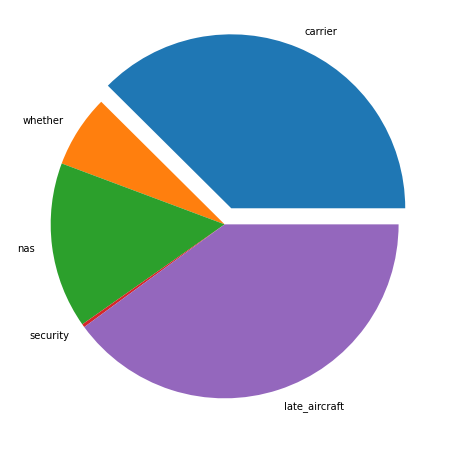

In [50]:
plt.figure(figsize=(12,8)) #그림크기 조절
label = ['carrier','whether','nas','security','late_aircraft'] #각 파이의 이름
explodes = [0.1,0,0,0,0] #첫번째 파이를 띄어서 보여주기
plt.pie(result,explodes,label) #파이차트 보여주기